# Práctica V. Aplicación de filtros Chebyshev tipo 1 y 2 digitales para la detección de frecuencia cardiaca mediante los sonidos de Korotkoff

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
from scipy import signal as sg
import sounddevice       as sd
from scipy.signal        import hilbert 
from scipy.signal        import find_peaks

In [2]:
""""Función para estimación de FFT en dB"""

def fou(senal,sr):
    """senal: señal a la que desea obtener la transformada de Fourier
    sr: Frecuencia de muestreo"""
    f = np.fft.fft(senal)
    h = 20*np.log10(np.abs(f))[:int(f.shape[0]/2)]
    w = np.linspace(0,sr/2,int(f.shape[0]/2))
    
    return h, w

In [3]:
"""Función para obtener la caracterización de filtros digitales"""

def freqz_plot(b,a,sr):
    """ba: coeficientes del diseño del filtro
    sr: Frecuencia de muestreo"""
    w,h     = sg.freqz(b,a)
    h[h==0] = 1E-5
    H       = 20*np.log10(np.abs(h))
    W       = np.angle(h)
    W       = np.unwrap(W)
    W       = np.degrees(W)
    w       = np.linspace(0,sr/2,H.shape[0])

    return w,W,H

In [109]:
"""Función para la detección de la frecuencia cardiaca"""

def frec_card(senal,sr,umbral):
    '''Para la detección de la frecuencia cardiaca, sabemos que los sonidos cardiacos son producidos latido a latido, por lo tanto, para conocer la frecuencia cardiaca, es necesario tener la frecuencia de repeticiones de los sonidos de Korotkoff.
    Se obtiene la envolvente de la señal, procedente de la posición de los picos.'''

    t = np.linspace(0,len(senal)/sr,len(senal))
    envolvente = hilbert(senal) #Función de hilbert regresa la envolvente de la señal
    envolvente = np.abs(envolvente)
    plt.figure(figsize=(12,5))
    plt.plot(t,envolvente)#gráfica de la envolvente de la señal
    
    #La función find_peaks encuentra la posición de los picos que fueron encontrados con un umbral definido 
    #picos: contiene un vector con la posición de los picos
    #altura: altura de cada uno de los picos 
    picos,altura = find_peaks(envolvente,height=umbral) 
    picos_t= picos/sr #Debido a que la posición está en muestras, se debe convertir a tiempo 
    plt.plot(picos_t,envolvente[picos],'x',color='red')
    plt.plot(t,umbral+np.zeros_like(t),'--',color='red')
    plt.legend(('Envolvente', 'Picos', 'Umbral'), prop = {'size':12}, loc = 'upper right')
    plt.xlabel('Tiempo[seg]',fontsize=15)
    plt.ylabel('Amplitud [v]',fontsize=15)
    plt.grid(True)
    
    frec = picos_t[1]-picos_t[0]
    frec = 60/frec
    frec = int(frec)
    print ('Frecuencia cardiaca:',frec)

In [4]:
datapath = 'C:\\Users\\HP desktop\\Documents\\Trimestre 19I\\Servicio social\\'

In [5]:
#Cargar el archivo npz de sonidos de Korotkoff 
sonidos = np.load(datapath+'data\\sonidos.npz')
for i in sonidos.keys(): #Observar las variables que se encuentran en el archivo npz
    print (i)

sonidos
sr


In [6]:
#Asignación de las variables que se encuentran en el archivo npz

sr      = sonidos['sr']
sonidos = sonidos['sonidos']

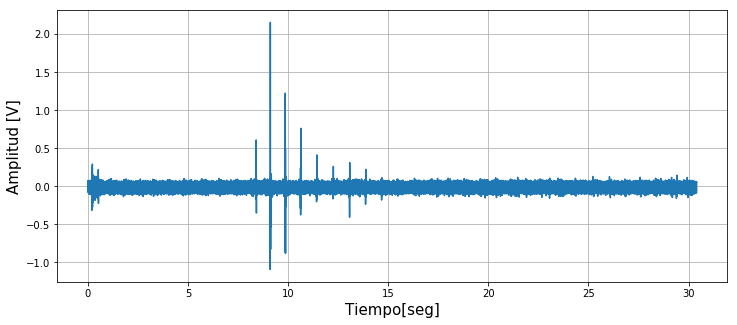

In [7]:
#Gráfica de señal de sonidos de Korotkoff
t = np.linspace(0,len(sonidos)/sr,len(sonidos))
plt.figure(figsize=(12,5))
plt.plot(t,sonidos)
plt.xlabel('Tiempo[seg]',fontsize=15)
plt.ylabel('Amplitud [V]',fontsize=15)
plt.grid(True)
plt.savefig(datapath+'images\\sounds')

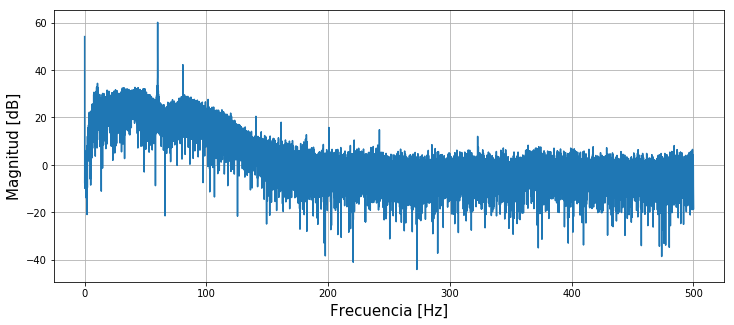

In [8]:
# FFT de la señal 

h,w = fou(sonidos,1000)
plt.figure(figsize=(12,5))
plt.plot(w,h)
plt.xlabel('Frecuencia [Hz]',fontsize=15)
plt.ylabel('Magnitud [dB]',fontsize=15)
plt.grid(True)
plt.savefig(datapath+'images\\FFT_sounds')

In [9]:
# Diseño de filtro chebyshev tipo 1 pasa banda orden 2
n = 2
fc = 2*np.array([23.,45.])/sr
b1,a1 = sg.cheby1(n,3,fc,btype='bandpass')

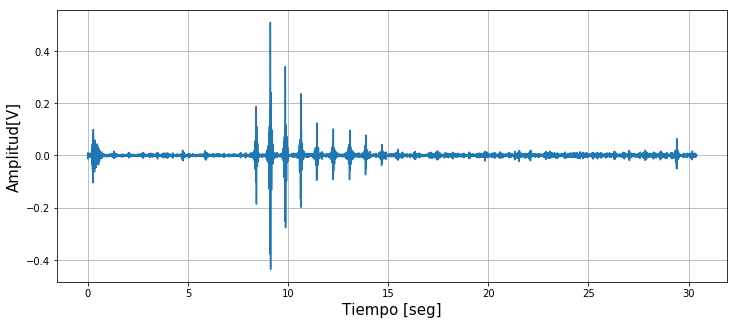

In [10]:
# Filtrado de la señal
sound1 = sg.lfilter(b1,a1,sonidos)
sound1 = sg.lfilter(b1,a1,sound1[::-1])[::-1]
plt.figure(figsize=(12,5))
plt.plot(t,sound1)
plt.xlabel('Tiempo [seg]',fontsize=15)
plt.ylabel('Amplitud[V]',fontsize=15)
plt.grid(True)

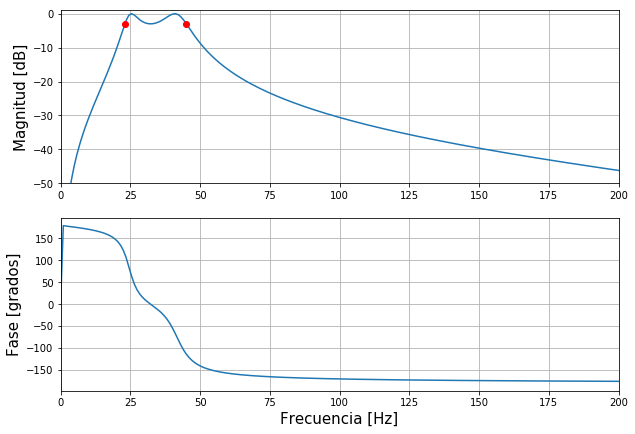

In [11]:
#Caracterización del filtro 
w1,W1,H1 = freqz_plot(b1,a1,sr)

plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(w1,H1)
plt.ylabel('Magnitud [dB]',fontsize=15)
plt.xlim(0,200)
plt.ylim(-50,1)
fc1 = plt.plot(23,-3, 'ro') # Frecuencia de corte 1 en la gráfica de magnitud
fc2 = plt.plot(45,-3,'ro') # Frecuencia de corte 2 en la gráfica de magnitud
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(w1,W1)
plt.ylabel('Fase [grados]',fontsize=15)
plt.xlabel('Frecuencia [Hz]',fontsize=15)
plt.xlim(0,200)
plt.grid(True)
plt.savefig(datapath+'images\\RF_C1S')

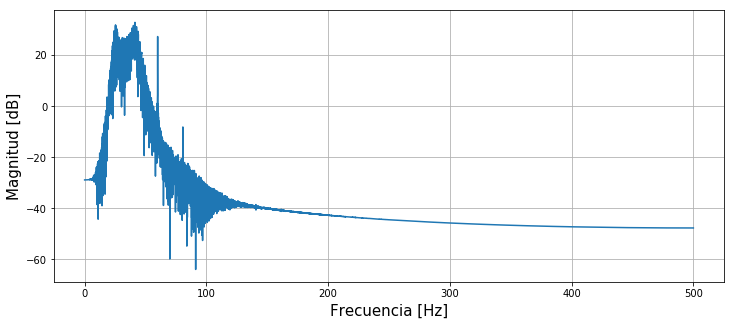

In [35]:
#FFT de la señal filtrada con Cheby1

h1,w1 = fou(sound1,sr)

plt.figure(figsize=(12,5))
plt.plot(w1,h1)
plt.xlabel('Frecuencia [Hz]',fontsize=15)
plt.ylabel('Magnitud [dB]',fontsize=15)
plt.grid(True)
plt.savefig(datapath+'images\\FFT_C1S')

Frecuencia cardiaca: 85


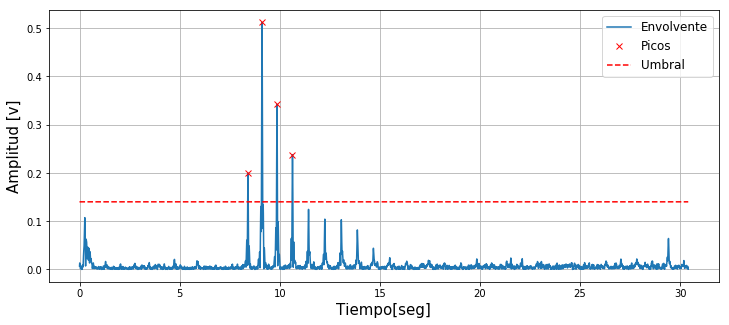

In [110]:
#Cheby1
frec_card(sound1,sr,0.14)
plt.savefig(datapath+'images\\frec1')

In [113]:
# Diseño de filtro chebyshev tipo 2 pasa banda orden 2
fc = 2*np.array([20.,55.])/sr
b2,a2 = sg.cheby2(n,15,fc,btype='bandpass')

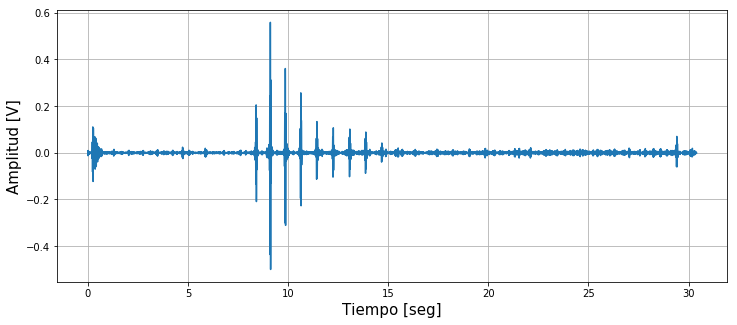

In [114]:
#Filtrado de la señal 
sound2 = sg.lfilter(b2,a2,sonidos)
sound2 = sg.lfilter(b2,a2,sound2[::-1])[::-1]

plt.figure(figsize=(12,5))
plt.plot(t,sound2)
plt.xlabel('Tiempo [seg]',fontsize=15)
plt.ylabel('Amplitud [V]',fontsize=15)
plt.grid(True)

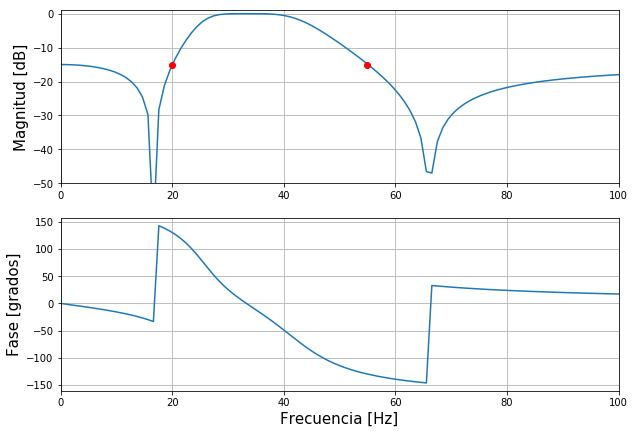

In [68]:
#Caracterización del filtro 
w2,W2,H2 = freqz_plot(b2,a2,sr)

plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(w2,H2)
plt.ylabel('Magnitud [dB]',fontsize=15)
plt.xlim(0,100)
plt.ylim(-50,1)
fc1 = plt.plot(20.0,-15, 'ro') # Frecuencia de corte 1 en la gráfica de magnitud
fc2 = plt.plot(55.,-15,'ro') # Frecuencia de corte 2 en la gráfica de magnitud
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(w2,W2)
plt.ylabel('Fase [grados]',fontsize=15)
plt.xlabel('Frecuencia [Hz]',fontsize=15)
plt.xlim(0,100)
plt.grid(True)
plt.savefig(datapath+'images\\RF_C2S')

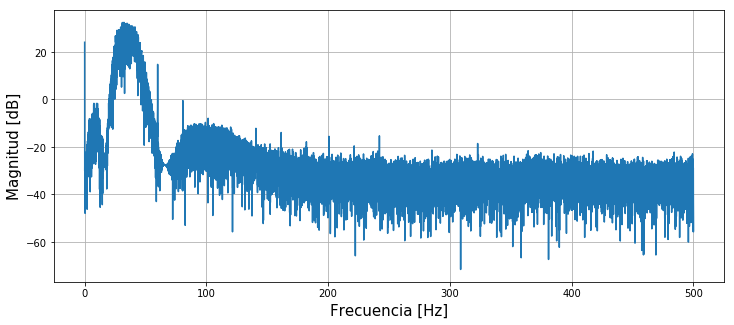

In [69]:
#FFT de la señal filtrada con cheby2
h2,w2 = fou(sound2,sr)

plt.figure(figsize=(12,5))
plt.plot(w2,h2)
plt.ylabel('Magnitud [dB]',fontsize=15)
plt.xlabel('Frecuencia [Hz]',fontsize=15)
plt.grid(True)
plt.savefig(datapath+'images\\FFT_C2S')

Frecuencia cardiaca: 85


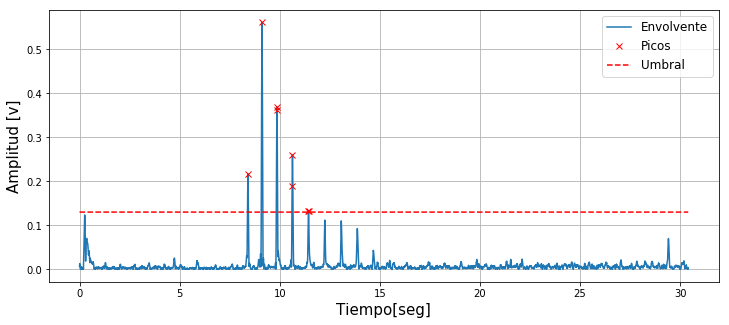

In [111]:
#Cheby2
frec_card(sound2,sr,0.13)
plt.savefig(datapath+'images\\frec2')